<a href="https://colab.research.google.com/github/kaiju8/GANs-Implemented/blob/main/WGAN_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loss-function data is informative, better stability avoids Mode **Collapse**. Longer to train

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from torchvision.utils import save_image
from torch.utils.data import DataLoader

from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Two base models were 1. an MLP with 4 hidden layers and 512 units at each layer 2. DCGAN as the Generator

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
lr = 5e-4 #vary 
z_dim = 100 #vary
img_dim = 64
channels_img = 1
batch_size = 64
num_epochs = 10

hidden_units = 512

critic_iter = 5
weight_clip = 0.01

In [5]:
class Critic(nn.Module):
    def __init__(self, channels):
        super(Critic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            #No Sigmoid here
        )

    def forward(self, x):
        return self.critic(x)

In [6]:
class Generator_MLP(nn.Module):
    def __init__(self, noise_dim, hidden_units, channels, img_dim):
        super(Generator_MLP, self).__init__()
        
        self.gen = nn.Sequential(
            nn.Flatten(),

            nn.Linear(noise_dim, hidden_units),  # First hidden layer
            nn.ReLU(inplace=True),

            nn.Linear(hidden_units, hidden_units),  # Second hidden layer
            nn.ReLU(inplace=True),

            nn.Linear(hidden_units, hidden_units),  # Third hidden layer
            nn.ReLU(inplace=True),
            
            nn.Linear(hidden_units, hidden_units),  # Fourth hidden layer
            nn.ReLU(inplace=True),

            nn.Linear(hidden_units, channels * img_dim * img_dim),  # Final layer
            nn.Tanh(),

            nn.Unflatten(1, torch.Size([channels, img_dim, img_dim]))
        )
    
    def forward(self, x):
        return self.gen(x)

In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
transformation = transforms.Compose(
    [
        transforms.Resize(img_dim),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),     
    ]
) 

dataset = datasets.MNIST(root = "dataset", transform = transformation, download = True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 130112353.95it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30420817.13it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 57627626.00it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18713682.48it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [9]:
critic = Critic(channels_img).to(device)
gen = Generator_MLP(z_dim, hidden_units, channels_img, img_dim).to(device)

In [10]:
print(summary(critic, input_size = (channels_img, img_dim, img_dim), batch_size = -42))
print(summary(gen, input_size = (z_dim, 1, 1), batch_size = -42))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-42, 64, 32, 32]           1,024
         LeakyReLU-2          [-42, 64, 32, 32]               0
            Conv2d-3         [-42, 128, 16, 16]         131,072
       BatchNorm2d-4         [-42, 128, 16, 16]             256
         LeakyReLU-5         [-42, 128, 16, 16]               0
            Conv2d-6           [-42, 256, 8, 8]         524,288
       BatchNorm2d-7           [-42, 256, 8, 8]             512
         LeakyReLU-8           [-42, 256, 8, 8]               0
            Conv2d-9           [-42, 512, 4, 4]       2,097,152
      BatchNorm2d-10           [-42, 512, 4, 4]           1,024
        LeakyReLU-11           [-42, 512, 4, 4]               0
           Conv2d-12             [-42, 1, 1, 1]           8,192
Total params: 2,763,520
Trainable params: 2,763,520
Non-trainable params: 0
---------------------------

In [11]:
initialize_weights(critic)
initialize_weights(gen)

opt_critic = optim.RMSprop(critic.parameters(), lr = lr)
opt_gen = optim.RMSprop(gen.parameters(), lr = lr)

In [12]:
fixed_noise = torch.randn((32, z_dim, 1, 1)).to(device)

In [13]:
def generate_img(generator, fixed_noise, channels, img_dim):
    
    fake = generator(fixed_noise).reshape(-1, channels, img_dim, img_dim)
    img_grid = torchvision.utils.make_grid(fake, normalize=True)
    return img_grid

def generate_interpolation(generator, z_dim, channels, img_dim):

    point_1 = torch.randn((1, z_dim, 1, 1)).to(device)
    point_2 = torch.randn((1, z_dim, 1, 1)).to(device)

    interpolated = point_1.detach().clone()
    for i in range(1, 16, 1):
        inter = torch.lerp(point_1, point_2,(i/15.0)).to(device)
        interpolated = torch.cat((interpolated, inter), 0).to(device)
        
    imgs = gen(interpolated).reshape(-1, channels_img, img_dim, img_dim)
    img_grid = torchvision.utils.make_grid(imgs, normalize=True)
    return img_grid

def show_grid(imgs): #Show function from documentation
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [14]:
def train_critic(real_img, fake_img, optim, critic):

    optim.zero_grad()

    # Train Critic Max E[critic(real)] - E[critic(fake)]

    critic_real = critic(real_img).reshape(-1)
    critic_fake = critic(fake_img).reshape(-1)

    loss_critic =  torch.mean(critic_fake) - torch.mean(critic_real)

    loss_critic.backward()
    
    optim.step()

    return loss_critic

def train_gen(fake_img, optim, critic):

    optim.zero_grad()
    
    # Train Gen Min -E[critic(fake)]

    output = critic(fake_img).reshape(-1)
    
    loss_gen = -torch.mean(output)

    loss_gen.backward()

    optim.step()

    return loss_gen

Epoch [0/10] Batch 0/938 Discriminator loss: -0.2690, Generator loss: 0.3210
Epoch [1/10] Batch 0/938 Discriminator loss: -1.5018, Generator loss: 0.7641
Epoch [2/10] Batch 0/938 Discriminator loss: -1.1767, Generator loss: 0.6166
Epoch [3/10] Batch 0/938 Discriminator loss: -1.1770, Generator loss: 0.5379
Epoch [4/10] Batch 0/938 Discriminator loss: -1.4501, Generator loss: 0.6932
Epoch [5/10] Batch 0/938 Discriminator loss: -1.3737, Generator loss: 0.6797
Epoch [6/10] Batch 0/938 Discriminator loss: -1.4132, Generator loss: 0.6718
Epoch [7/10] Batch 0/938 Discriminator loss: -1.2756, Generator loss: 0.6285
Epoch [8/10] Batch 0/938 Discriminator loss: -1.1304, Generator loss: 0.5083
Epoch [9/10] Batch 0/938 Discriminator loss: -0.9418, Generator loss: 0.5345


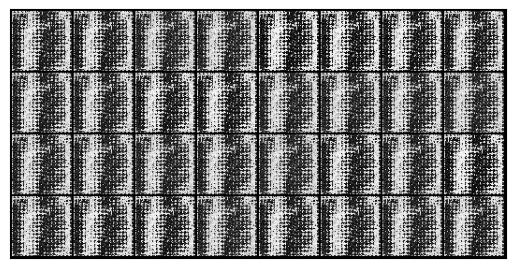

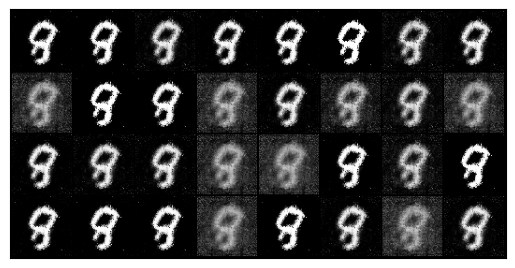

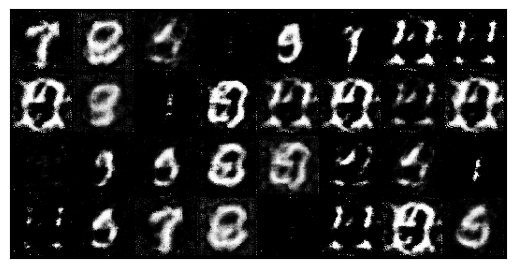

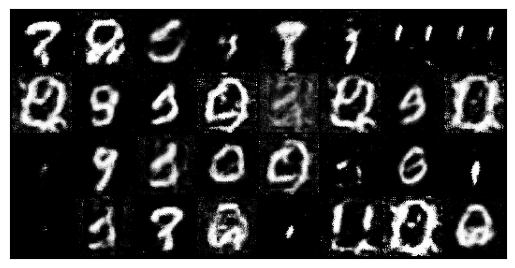

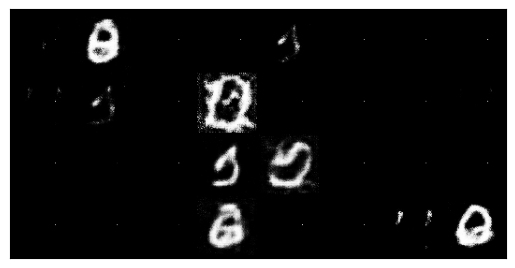

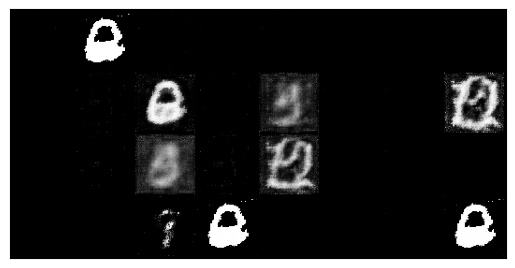

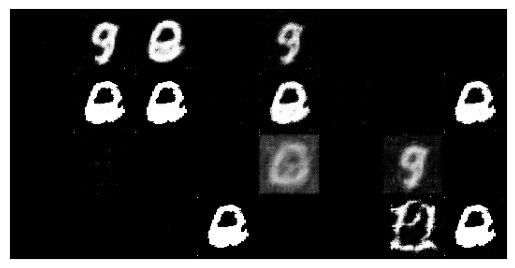

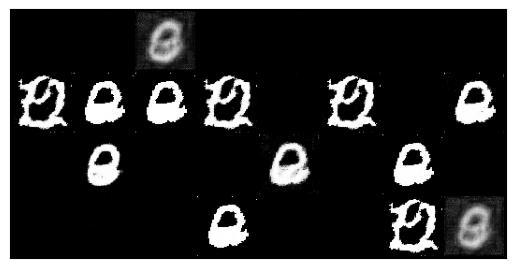

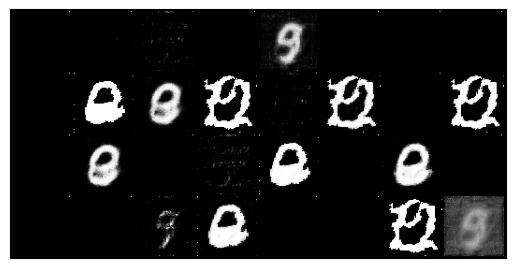

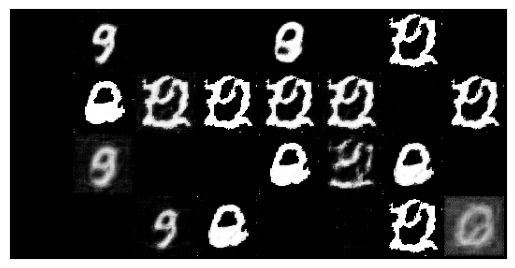

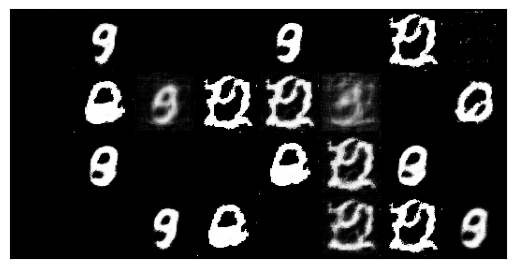

In [15]:
losses_c = []
losses_g = []

for epoch in range(num_epochs):

    loss_c = 0.0
    loss_g = 0.0

    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        batch_size = real.shape[0]
        

        for _ in range(critic_iter):
            noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
            fake = gen(noise).detach()

            loss_c_i = train_critic(real, fake, opt_critic, critic)
            loss_c = loss_c + loss_c_i.detach().cpu()
            
            for para in critic.parameters():
                para.data.clamp_(-weight_clip, weight_clip)

        loss_c = loss_c/critic_iter 
        losses_c.append(loss_c)

        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)

        loss_g = train_gen(fake, opt_gen, critic)
        losses_g.append(loss_g.detach().cpu())


###################################################
        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} Discriminator loss: {loss_c:.4f}, Generator loss: {loss_g:.4f}")

            with torch.no_grad():
                show_grid(generate_img(gen, fixed_noise, channels_img, img_dim))
####################################################

show_grid(generate_img(gen, fixed_noise, channels_img, img_dim))

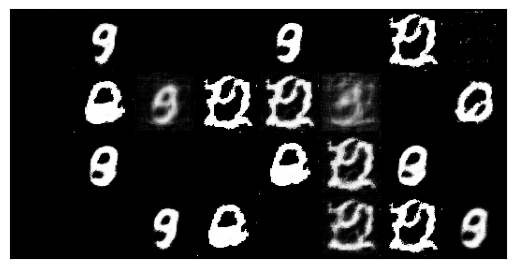

In [16]:
sample_img = generate_img(gen, fixed_noise, channels_img, img_dim)
show_grid(sample_img)
save_image(sample_img, "result.png")

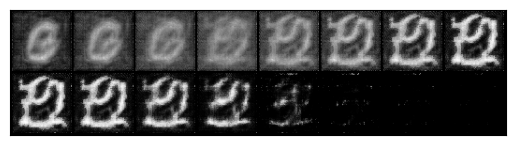

In [17]:
interpolation_img = generate_interpolation(gen, z_dim, channels_img, img_dim)
show_grid(interpolation_img)
save_image(interpolation_img, "interpolation.png")

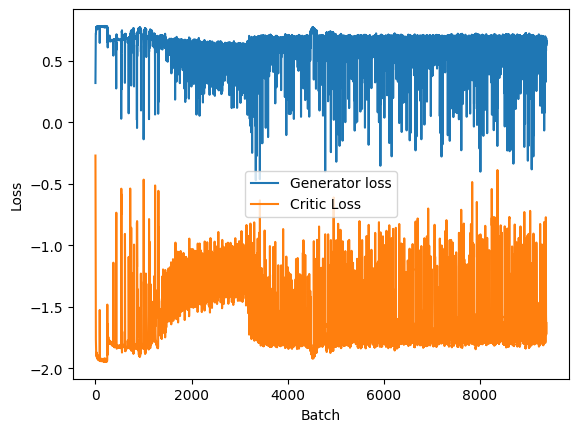

In [18]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_c, label='Critic Loss')
plt.legend()
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.savefig("loss.png")
plt.show()